In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.model_selection import train_test_split

from sklearn import neighbors
from sklearn import preprocessing
from sklearn import decomposition
from sklearn import cluster, metrics

import statsmodels
from scipy.stats import t, shapiro

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
import os
import warnings

In [3]:
warnings.filterwarnings('ignore')

In [4]:
os.listdir()

['.ipynb_checkpoints',
 'billets.csv',
 'billets_production.csv',
 'Cahier des charges P10.pdf',
 'Modelisations de données performantes',
 'Ocon_1_code_022023-Copy1.ipynb',
 'Ocon_1_code_022023.ipynb',
 'Ocon_1_code_022023.zip',
 'P10 Jorge _ B.ipynb',
 'P10 Jorge-Copy1.ipynb',
 'P10 Jorge.ipynb',
 'Untitled.ipynb',
 'Untitled1.ipynb',
 'Untitled2-Copy1.ipynb',
 'Untitled2.ipynb',
 'xOcon_1_code_022023.zip']

### Preparation des données

In [5]:
file = "billets.csv"
billets = pd.read_csv(file, sep=";")
billets.head(2)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09


#### structure

In [6]:
billets.info() # A priori il y a 37 valeurs manquantes dans la colonne margin_low

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [7]:
billets.nunique() 

is_genuine        2
diagonal        159
height_left     155
height_right    170
margin_low      285
margin_up       123
length          336
dtype: int64

In [8]:
billets.duplicated().sum() #Pas des duplicates

0

#### Regression lineaire multiple pour la prediction des nulls 

In [9]:
billets_nn = billets.loc[billets.margin_low.notnull()] #Df avec les données non nuls
billets_nn.shape

(1463, 7)

<AxesSubplot:>

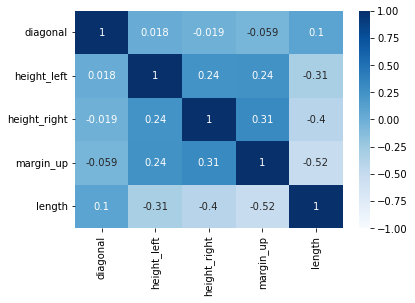

In [10]:
# On observe la colinearité

m_corr = billets_nn.drop(columns=['is_genuine', 'margin_low'], axis=1).corr()
sns.heatmap(m_corr, vmax = 1, vmin=-1, annot=True, cmap = 'Blues')

In [11]:
#On initialise la regression multiple:
reg_multi = smf.ols('margin_low~diagonal+height_left+height_right+margin_up+length', data=billets_nn).fit() 
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Fri, 03 Feb 2023   Prob (F-statistic):          2.60e-202
Time:                        19:00:59   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       22.9948      9.656      2.382   

Tous les variables sont significatives p>0.05% et donc on les utiliser pour la prediction

In [12]:
a_prevoir = billets.loc[billets.margin_low.isnull()] #creation du df avec seulement les valeurs nuls
a_prevoir.head(2)
b_prevoir = a_prevoir.copy() #copy

In [13]:
a_prevoir.drop(columns = ["margin_low", "is_genuine"], inplace=True) #drop la colonne a predire pour ensuite l'ajouter

In [14]:
a_prevoir.shape

(37, 5)

In [15]:
ml_prev = reg_multi.predict(a_prevoir) #Array avec les valeurs predicts par la regression lineaire a partir de a_prevoir
ml_prev.shape

(37,)

In [16]:
b_prevoir.margin_low = ml_prev #ajout de la colonne a predire (margin_low)
b_prevoir.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,171.94,103.89,103.45,4.318525,3.25,112.79
99,True,171.93,104.07,104.18,4.393668,3.14,113.08
151,True,172.07,103.80,104.38,4.410457,3.02,112.93
197,True,171.45,103.66,103.80,4.319014,3.62,113.27
241,True,171.83,104.14,104.06,4.650617,3.02,112.36


In [17]:
billets.update(b_prevoir) #update du df principal

In [57]:
billets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   object 
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1500 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: float64(6), object(1)
memory usage: 82.2+ KB


##### Check la colinéarité des variables

In [18]:
variables = reg_multi.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.0136128990686313,
 1.13826057360825,
 1.2301145155560365,
 1.404403778184361,
 1.5769501453665822]

Ici, tous les coefficients sont inférieurs à 10, il n'y a donc pas de problème de colinéarité.

##### Test d'homoscédasticité

On peut également tester l’homoscédasticité (c'est-à-dire la constance de la variance) des résidus :

In [19]:
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(reg_multi.resid, variables)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 7.759535216219784e-16


La p-valeur ici est inférieure à $5$%, on rejette l'hypothèse $H0$ selon laquelle les variances sont constantes (l'hypothèse d’homoscédasticité).

##### Test de normalité des résidus

Pour tester la normalité des résidus on fait un test de Shapiro-Wilk.

In [20]:
shapiro(reg_multi.resid)

ShapiroResult(statistic=0.9857879281044006, pvalue=8.536943374437556e-11)

Ici, l'hypothèse de normalité est refuté p-value < 0.05).

' Néanmoins, l'observation des résidus, le fait qu'ils ne soient pas très différents d'une distribution symétrique, et le fait que l'échantillon soit de taille suffisante (supérieure à 30) permettent de dire que **les résultats obtenus par le modèle linéaire gaussien ne sont pas absurdes**, même si le résidu n'est pas considéré comme étant gaussien. ' : Vincent Lefieux

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

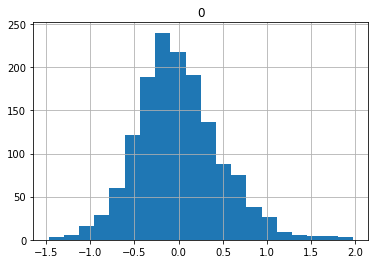

In [21]:
x = pd.DataFrame(reg_multi.resid)
x.hist(bins=20)

Dataset prêt ! 

In [22]:
billets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   object 
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1500 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: float64(6), object(1)
memory usage: 82.2+ KB


##### Train and test ! 
Separation du df pour comparer les resultats de la prediction du model.

In [23]:
cols = billets.columns
X_train, X_test, Y_train, Y_test = train_test_split(billets[cols[1:]], billets['is_genuine'], random_state=0)

In [24]:
bilets_train = pd.concat([Y_train, X_train], axis=1)

In [25]:
bilets_train.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
247,True,172.45,103.97,104.32,4.15,3.23,113.45
678,True,172.15,103.65,103.66,3.60,3.50,113.24
722,True,172.30,104.04,103.93,4.33,2.92,113.19
590,True,171.85,103.58,104.17,4.32,3.07,113.59
186,True,172.21,103.48,104.04,4.40,3.00,113.15


### Prediction des vraies ou faux billets.

##### Regresion logistique.

Il faut d'abord transformer le type de données de la colonne a predire (is genuine) du boolean à int, soit du True False à 0 et 1.

In [26]:
bilets_train.is_genuine = bilets_train.is_genuine.astype(int)
bilets_train.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
247,1,172.45,103.97,104.32,4.15,3.23,113.45
678,1,172.15,103.65,103.66,3.60,3.50,113.24
722,1,172.30,104.04,103.93,4.33,2.92,113.19
590,1,171.85,103.58,104.17,4.32,3.07,113.59
186,1,172.21,103.48,104.04,4.40,3.00,113.15


On commence la rgeression linaire:

In [27]:
reg_log = smf.glm('is_genuine~diagonal+height_left+height_right+margin_low+margin_up+length',
                   data=bilets_train, family=sm.families.Binomial()).fit()
print(reg_log.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             is_genuine   No. Observations:                 1125
Model:                            GLM   Df Residuals:                     1118
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -35.083
Date:                Fri, 03 Feb 2023   Deviance:                       70.165
Time:                        19:01:00   Pearson chi2:                 1.03e+03
No. Iterations:                    10   Pseudo R-squ. (CS):             0.7016
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     -100.1879    255.253     -0.393   

On supprime la variable moins significative 'Diagonal' et on recommence

In [28]:
reg_log = smf.glm('is_genuine~height_left+height_right+margin_low+margin_up+length',
                   data=bilets_train, family=sm.families.Binomial()).fit()
print(reg_log.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             is_genuine   No. Observations:                 1125
Model:                            GLM   Df Residuals:                     1119
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -35.111
Date:                Fri, 03 Feb 2023   Deviance:                       70.223
Time:                        19:01:00   Pearson chi2:                 1.03e+03
No. Iterations:                    10   Pseudo R-squ. (CS):             0.7016
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -54.4954    169.190     -0.322   

On supprime la variable moins significative 'height_left' et on recommence

In [29]:
reg_log = smf.glm('is_genuine~height_right+margin_low+margin_up+length',
                   data=bilets_train, family=sm.families.Binomial()).fit()
print(reg_log.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             is_genuine   No. Observations:                 1125
Model:                            GLM   Df Residuals:                     1120
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -36.443
Date:                Fri, 03 Feb 2023   Deviance:                       72.886
Time:                        19:01:00   Pearson chi2:                 1.32e+03
No. Iterations:                    10   Pseudo R-squ. (CS):             0.7009
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     -194.8119    150.406     -1.295   

Model prêt, time to predict ! 

In [30]:
test_1 = reg_log.predict(X_test[["height_right", "margin_low", "margin_up", "length"]])

In [31]:
test_1

471     9.978394e-01
9       9.994779e-01
1499    1.737794e-02
54      6.678565e-01
1411    1.135990e-07
            ...     
75      9.138866e-01
481     1.000000e+00
1350    4.006403e-05
748     9.999845e-01
1362    3.148188e-01
Length: 375, dtype: float64

In [32]:
Prediction_1 = pd.DataFrame(test_1.round(0)) #creation du df avec les resultats des predictions 
Prediction_1["observe"] = Y_test #On ajoute la colonne observe pour mettre côte à côte les predictions avec les vrais valeurs
Prediction_1.head()

,0,observe
471,1.0,True
9,1.0,True
1499,0.0,False
54,1.0,True
1411,0.0,False


In [33]:
pd.crosstab(Prediction_1[0], Prediction_1["observe"]) #crosstabb pour voir les resultats !!!

observe,False,True
0,,
0.0,125,1
1.0,1,248


In [34]:
Prediction_1['observe'] = Prediction_1['observe'].astype('int') #On va du bool to int
m_c = pd.DataFrame(metrics.confusion_matrix(Prediction_1["observe"], Prediction_1[0])) #creation de la matrice de confusion
m_c

,0,1
0,125,1
1,1,248


In [35]:
#accuracy : Pourcentageb des predictions correctes
print(metrics.accuracy_score(Prediction_1["observe"], Prediction_1[0]))

0.9946666666666667


The results are 0.994% correct !!!  !

##### K-means prediction

K-means k-means k-means k-means

In [36]:
X = X_train.values

In [37]:
Y = Y_train

In [38]:
print (X.shape)
print (Y.shape)

(1125, 6)
(1125,)


In [39]:
X_norm = preprocessing.scale(X)
#X_norm = preprocessing.scale(X)#scale des données du X_train
print(X_norm.shape)

(1125, 6)


In [40]:
pca = decomposition.PCA(n_components=2) #On utilise deux components pour montrer la separation des faux et vrais billets
pca.fit(X_norm)
print(pca.explained_variance_ratio_.cumsum())
X_trans = pca.transform(X_norm)

[0.43382206 0.60140617]


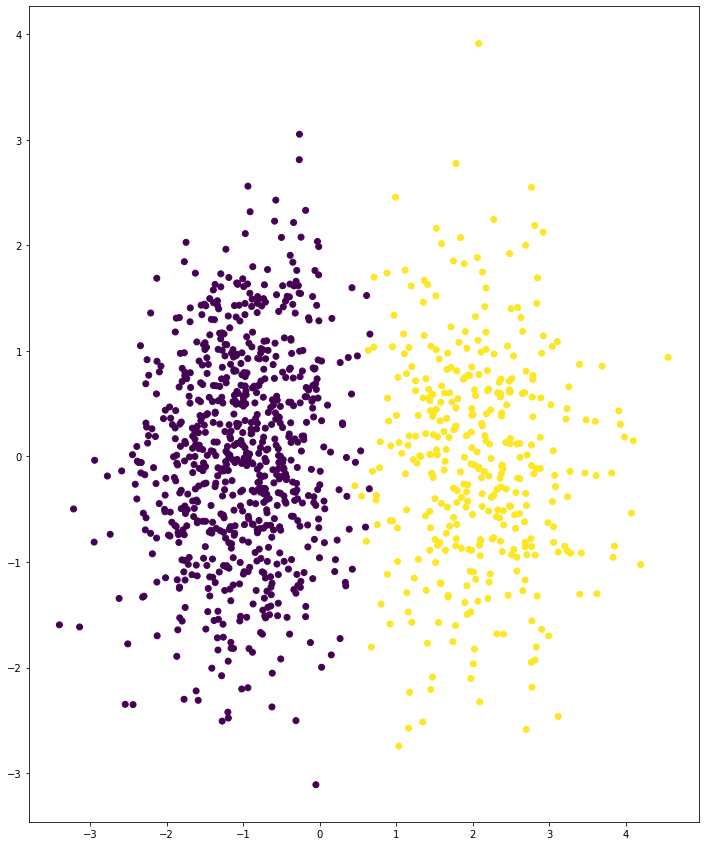

In [41]:
fig = plt.figure(figsize=(12,15)) 

cls = cluster.KMeans(n_clusters=2)
cls.fit(X_norm)
ax = fig.add_subplot()
ax.scatter(X_trans[: , 0], X_trans[:, 1], c = cls.labels_)

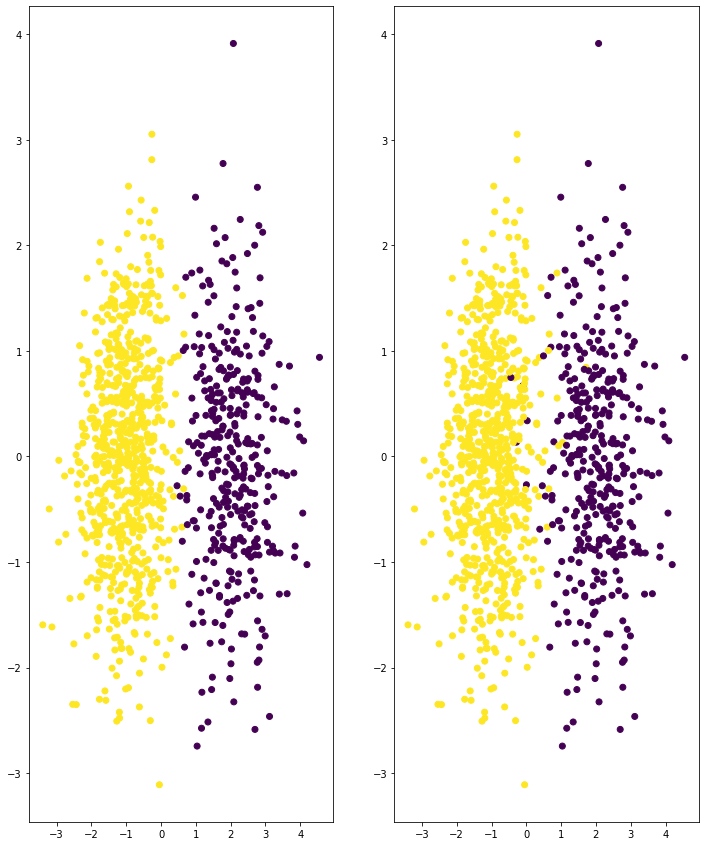

In [42]:
fig = plt.figure(figsize=(12,15)) #On met côte à côte les clusters avec les predictions(droite) et les vrais valeurs (gauche)

cls = cluster.KMeans(n_clusters=2)
cls.fit(X_norm)
ax = fig.add_subplot(121)
ax.scatter(X_trans[: , 0], X_trans[:, 1], c = cls.labels_)

ax = fig.add_subplot(122)
ax.scatter(X_trans[: , 0], X_trans[:, 1], c = Y)

In [43]:
prediction_2 = pd.DataFrame(cls.labels_)
prediction_2['observe'] = pd.DataFrame(Y_train).reset_index().drop(columns='index')
prediction_2

,0,observe
0,1,True
1,1,True
2,1,True
3,1,True
4,1,True
...,...,...
1120,1,True
1121,1,True
1122,0,False
1123,1,True


In [44]:
pd.crosstab(prediction_2[0], prediction_2["observe"]) #crosstabb pour voir les resultats !!!

observe,False,True
0,,
0,366,6
1,8,745


In [45]:
prediction_2['observe'] = prediction_2['observe'].astype('int') #On va du bool to int
m_c = pd.DataFrame(metrics.confusion_matrix(prediction_2["observe"], prediction_2[0])) #creation de la matrice de confusion
m_c

,0,1
0,366,8
1,6,745


In [46]:
#accuracy : Pourcentageb des predictions correctes
print(metrics.accuracy_score(prediction_2["observe"], prediction_2[0]))

0.9875555555555555


Les resultats sont corrects 98% du temps  

In [48]:
print(metrics.adjusted_rand_score(Y, cls.labels_) ) 

0.950164949668504


#### Test du model !! avec les donnes de l'entreprise !!!!

In [63]:
test_billets = pd.read_csv('billets_test.csv')
test_billets.head(20)

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,172.09,103.95,103.73,4.39,3.09,113.19,B_1
1,171.52,104.17,104.03,5.27,3.16,111.82,B_2
2,171.78,103.80,103.75,3.81,3.24,113.39,B_3
3,172.02,104.08,103.99,5.57,3.30,111.10,B_4
4,171.79,104.34,104.37,5.00,3.07,111.87,B_5


In [59]:
def test_reg_log(test):
    test_rlg = reg_log.predict(test[["height_right", "margin_low", "margin_up", "length"]])
    pred = pd.DataFrame(test_rlg.round(0))
    pred = pd.concat([test, pred], axis=1)
    pred.rename(columns = {0:'reg_log'}, inplace = True)
    return pred

In [60]:
y_ = test_reg_log(test_billets)

In [62]:
y_.head(20)

,diagonal,height_left,height_right,margin_low,margin_up,length,id,reg_log
0,172.09,103.95,103.73,4.39,3.09,113.19,B_1,1.0
1,171.52,104.17,104.03,5.27,3.16,111.82,B_2,0.0
2,171.78,103.80,103.75,3.81,3.24,113.39,B_3,1.0
3,172.02,104.08,103.99,5.57,3.30,111.10,B_4,0.0
4,171.79,104.34,104.37,5.00,3.07,111.87,B_5,0.0


#### Merci 